In [1]:
import torch
from torch import nn as nn
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm import tqdm
from sktime.libs.vmdpy import VMD
from scipy.signal import firwin, lfilter, correlate, find_peaks

In [2]:
data = pd.read_csv("data/3号机组抽水态健康样本.csv",encoding="GBK")
X=data.iloc[:,13:]
y=data.iloc[:,1]
sc = MinMaxScaler()
y = sc.fit_transform(np.array(y).reshape(-1,1))

In [213]:
import scipy.io as sio
 
# data = {'key1': value1, 'key2': value2, ...}  # 准备要保存的数据，可以是字典形式
data = {"x":y}
sio.savemat('x.mat', data)  # 保存为MAT文件

In [160]:
#汉宁窗口初始化FIR滤波器组
def initialize_filters(L, K):
    filters = []
    for k in range(1, K+1):
        cutoff = 0.5 / k
        filter = firwin(L, cutoff, window='hann')
        filters.append(filter)
    return filters
#自相关普
def estimate_period(signal):
    correlation = correlate(signal, signal, mode='full')
    correlation = correlation[len(correlation) // 2:]
    peaks, _ = find_peaks(correlation)
    if len(peaks) > 1:
        period = peaks[1]
    else:
        period = len(signal)
    return period

 #FMD函数
def fmd(signal, n, L=100, max_iters=10):
    K = min(10, max(5, n))
    filters = initialize_filters(L, K)
    modes = []
    signal = signal.values.flatten() if isinstance(signal, pd.DataFrame) else signal.flatten()
 
    for i in range(max_iters):
        for filter in filters:
            filtered_signal = lfilter(filter, 1.0, signal)
            period = estimate_period(filtered_signal)
            modes.append(filtered_signal)
 
        if len(modes) >= n:
            break
 
    return modes[:n]

In [29]:
from sktime.libs.vmdpy import VMD

In [30]:
alpha = 2000  # 中等带宽约束
tau = 0.0  # 容忍噪声（不强制保真度）
K = 4  # 预期3个模式
DC = 0  # 不施加直流部分的约束
init = 1  # 统一初始化频域系数
tol = 1e-7
f=y

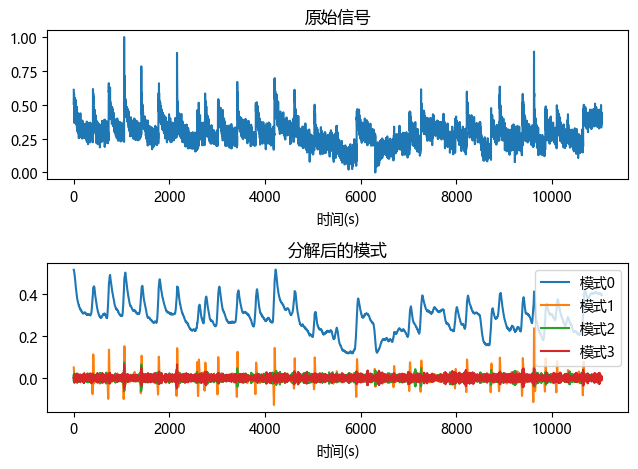

In [31]:
u, u_hat, omega = VMD(f, alpha, tau, K, DC, init, tol)

# 可视化分解后的模式
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei'] 
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(f)
plt.title("原始信号")
plt.xlabel("时间(s)")
plt.subplot(2, 1, 2)
plt.plot(u.T)
plt.title("分解后的模式")
plt.xlabel("时间(s)")
plt.legend([f"模式{m_i}" for m_i in range(u.shape[0])])
plt.tight_layout()

In [32]:
y=u[0]

In [33]:
seg_len = 5
serise = np.array([y[i:i+seg_len] for i in range(X.shape[0]-seg_len)])
serise = serise.reshape(serise.shape[0],serise.shape[1],1)
target = np.array(y[seg_len:]).reshape(-1,1)


In [ ]:
nn.Linear(in_features=10,out_features=1).forward(torch.rand(10,10))

In [145]:
x = torch.randn(10,1,10)
hidden = ((torch.zeros(2, x.size(0), 10)),
                  (torch.zeros(2, x.size(0), 10)))

x=nn.LSTM(input_size=10,hidden_size=10,num_layers=2,batch_first=True).forward(x,hidden)[0]
# x = x.view(len(x),-1)
x.shape

torch.Size([10, 1, 10])

In [34]:
class LSTM(nn.Module):
    def __init__(self, feature_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size  # 隐层大小
        self.num_layers = num_layers  # lstm层数
        # feature_size为特征维度，就是每个时间点对应的特征数量，这里为1
        self.lstm = nn.LSTM(feature_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden=None):
        batch_size = x.shape[0] # 获取批次大小
        
        # 初始化隐层状态
        if hidden is None:
            h_0 = x.data.new(self.num_layers, batch_size, self.hidden_size).fill_(0).float()
            c_0 = x.data.new(self.num_layers, batch_size, self.hidden_size).fill_(0).float()
        else:
            h_0, c_0 = hidden
            
        # LSTM运算
        output, (h_0, c_0) = self.lstm(x, (h_0, c_0))
        
        # 全连接层
        output = self.fc(output)  # 形状为batch_size * timestep, 1
        
        # 我们只需要返回最后一个时间片的数据即可
        return output[:, -1, :]

In [35]:
class LSTMmodel(nn.Module):
    def __init__(self,input_dim,hidden_num,out_dim):
        
        super().__init__()
        self.hidden_size=hidden_num
        self.in_size=input_dim
        self.out_size = out_dim
        self.lstm_layer = nn.LSTM(input_size=input_dim,hidden_size=hidden_num,batch_first=True)
        self.hidden_layer = nn.Linear(in_features=hidden_num,out_features=out_dim)

    def forward(self,x_in):

        lstmout, _ = self.lstm_layer(x_in)
        x_in = self.hidden_layer(lstmout)
        return x_in[:,-1,:]

In [40]:
train_dataset=TensorDataset(
    torch.Tensor(
        serise[:int(len(serise)*0.7)]
        )
    ,torch.Tensor(
        target[:int(len(serise)*0.7)]
        )
    )
test_dataset=TensorDataset(
    torch.Tensor(
        serise[int(len(serise)*0.7):]
        ),
    torch.Tensor(
        target[int(len(serise)*0.7):]
        )
    )

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [45]:
def train_model(model, model_name, epochs=50, learning_rate=0.01):
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    for epoch in tqdm(range(epochs), desc=f'Training {model_name}'):
        model.train()
        epoch_loss = 0
        for inputs, targets in train_loader:
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

    return model, train_losses

In [46]:
model, train_losses=train_model(LSTMmodel(1,2,1),"LSTM")

Training LSTM: 100%|██████████| 50/50 [00:28<00:00,  1.73it/s]


In [43]:
model, train_losses=train_model(LSTM(1,2,1,1),"LSTM")

Training LSTM: 100%|██████████| 30/30 [00:17<00:00,  1.68it/s]


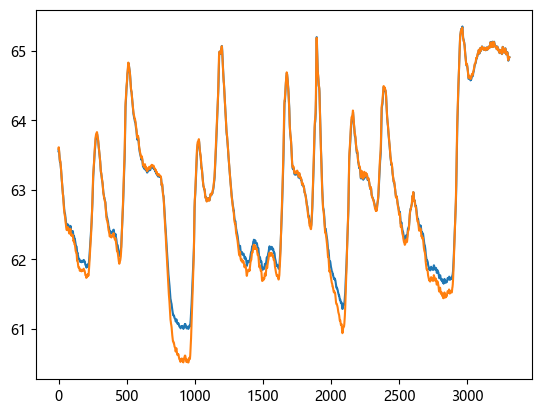

In [47]:
plt.plot(sc.inverse_transform(model.forward(test_loader.dataset.tensors[0]).detach().numpy().reshape(-1,1)))
plt.plot(sc.inverse_transform(test_loader.dataset.tensors[1].detach().numpy().reshape(-1,1)))